## Data Info

- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

## Preprocessing

In [1]:
# load necessary libraries
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import os
from os.path import join

import sklearn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# directory for kaggle, use this cell if intended for kaggle, otherwise your own directory should suffice
# set directory, load files, and check data shapes
# train_path = join('../input', 'train.csv') # might need to update path depending on where you upload file
# test_path = join('../input', 'test.csv')

In [3]:
# set directory, load files, and check data shapes
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(data.shape)
print(test.shape)

(15035, 21)
(6468, 20)


### Quick Data Overview

In [4]:
# data and test info
print(data.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [5]:
# simple stats of the df
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


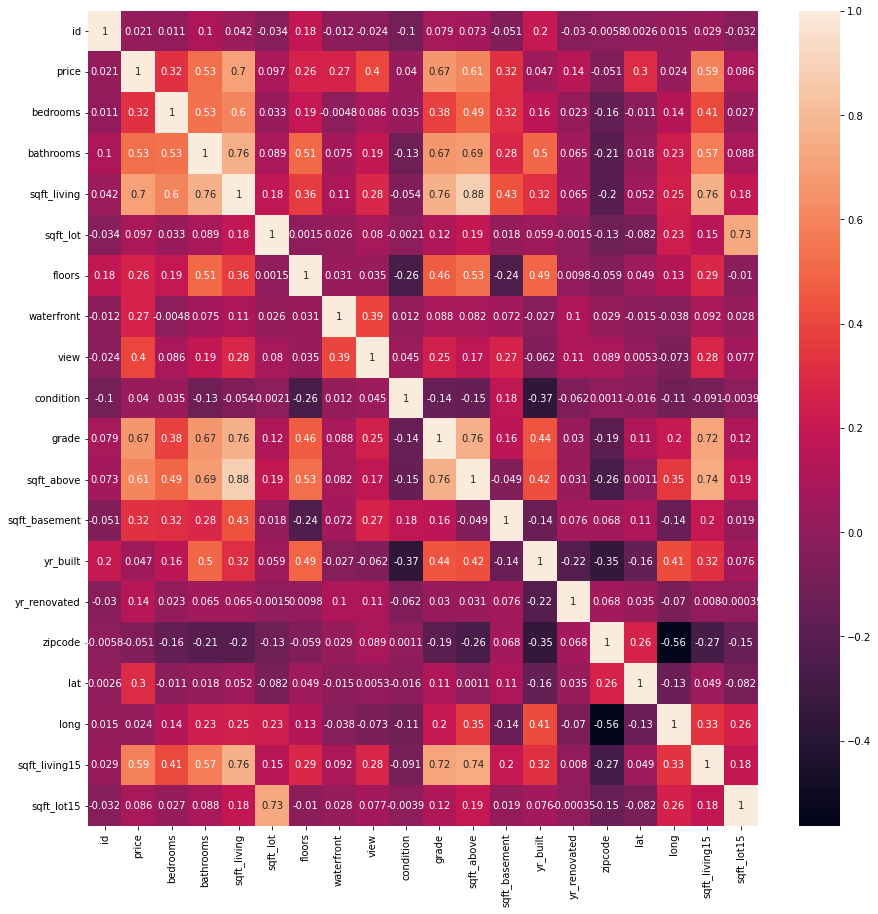

In [6]:
# heatmap for correlation between cols
plt.figure(figsize=(15,15))
sns.heatmap(data=data.corr(), annot=True)
plt.show()

In [7]:
# assign price to variable y and remove price column from data
# price is our target
y = data['price']
print(y.head())

data = data.drop(['price'], axis=1)
data.head()

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
# concatenate train and test sets to easily check any null vals and remove unnecessary columns
train_len = len(data)
data = pd.concat((data, test), axis=0)
print(train_len)
print(len(data))

15035
21503


<AxesSubplot:>

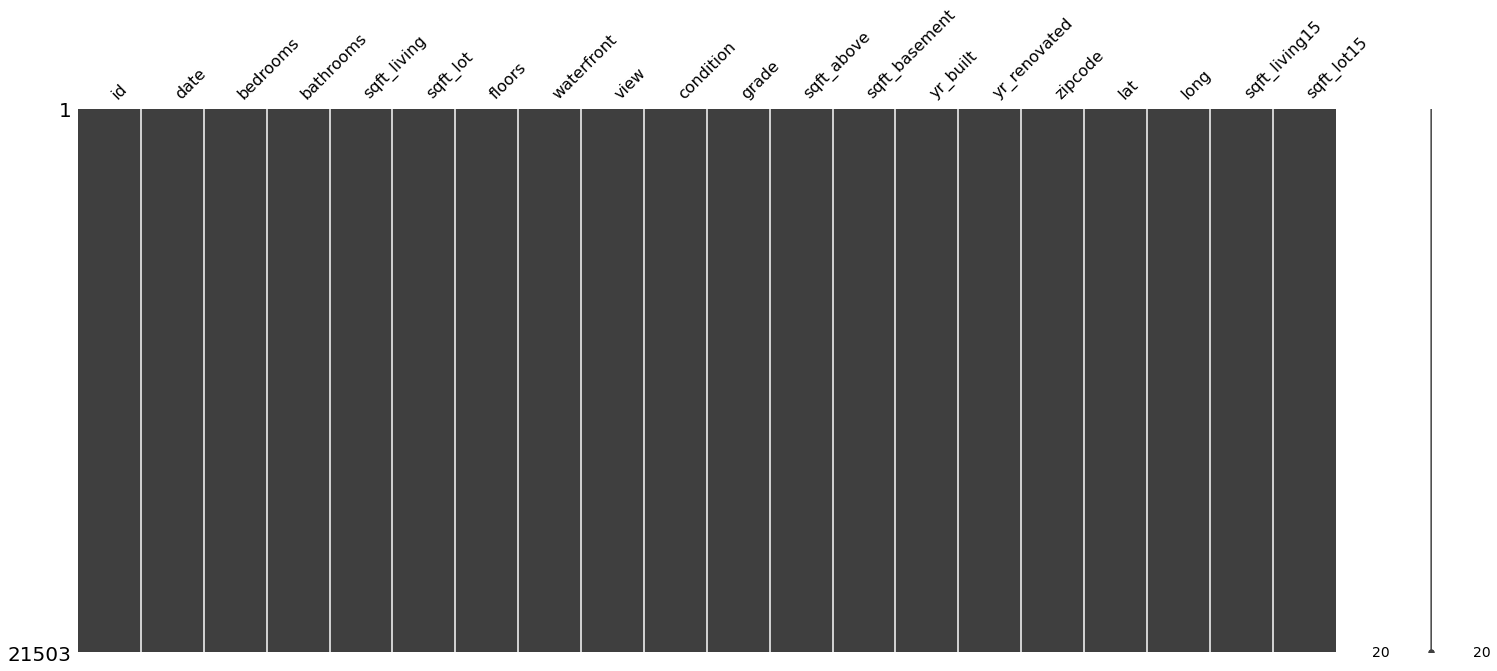

In [9]:
# using missingno matrix to check null vals
msno.matrix(data)

In [10]:
# another way to check any null vals
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [11]:
# need id for submission later, so assigning to a variable
test_id = data['id'][train_len:]
del data['id']

### Log Scaling columns

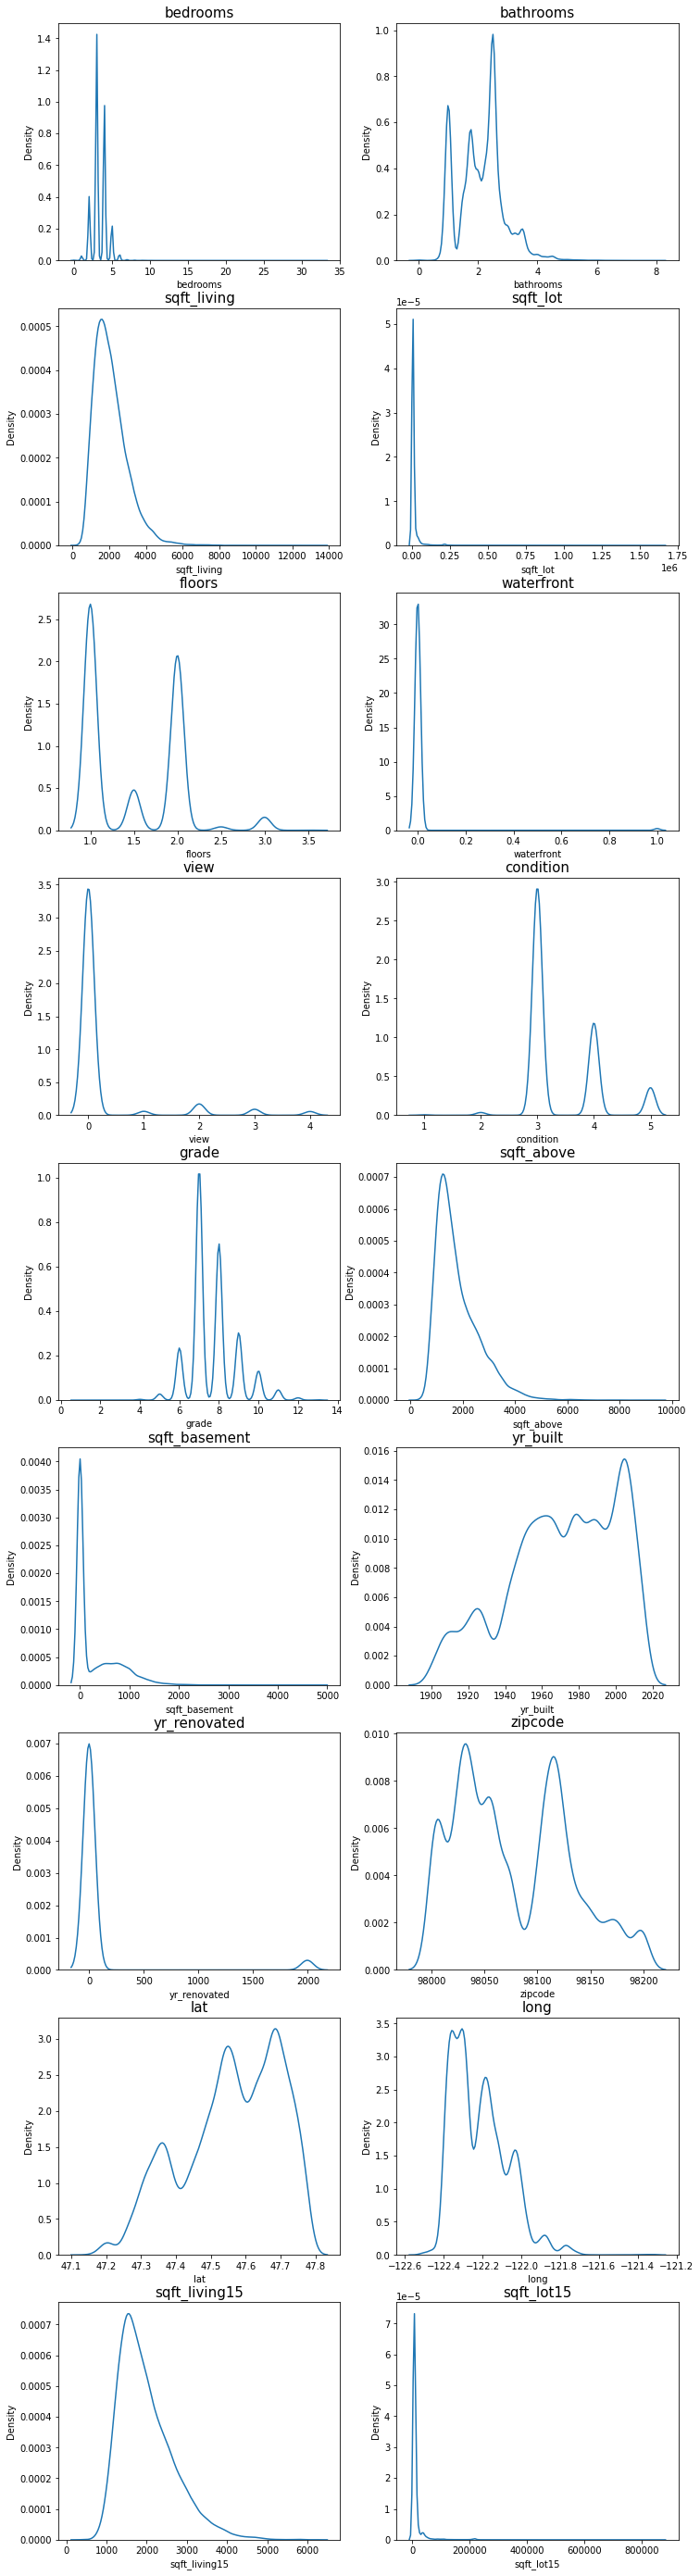

In [12]:
# kdeplots for dist of each cols
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1

columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

Chose some columns to be log scaled based on the above plots in order to redue loss function.

In [13]:
# log scale certain columns
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15', 'yr_renovated']

for col in skew_columns:
    data[col] = np.log1p(data[col].values)

<AxesSubplot:xlabel='price', ylabel='Density'>

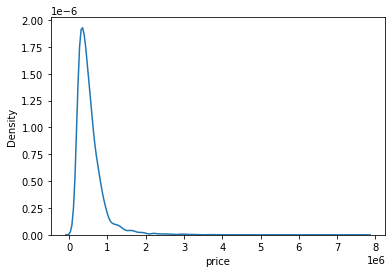

In [14]:
# checking dist of label/target
sns.kdeplot(y)

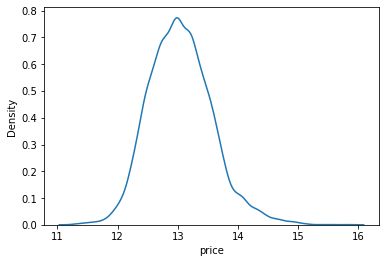

In [15]:
# log scaling label as well, since above plot shows that the target is tilted
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

### Rest of preprocessing

In [16]:
# slice date col to year and month, then change dtype to int
data['date'] = data['date'].apply(lambda x: x[:6]).astype(int)

In [17]:
# one-hot encoding waterfront col
data = pd.get_dummies(data, columns=['waterfront'])
data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_0,waterfront_1
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,3,7,7.074117,0.000000,1955,0.0,98178,47.5112,-122.257,7.201171,8.639588,1,0
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,3,6,6.647688,0.000000,1933,0.0,98028,47.7379,-122.233,7.908755,8.995041,1,0
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,3,8,7.427144,0.000000,1987,0.0,98074,47.6168,-122.045,7.496097,8.923191,1,0
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,3,7,7.447751,0.000000,1995,0.0,98003,47.3097,-122.327,7.713785,8.827615,1,0
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,3,7,6.966967,0.000000,1963,0.0,98198,47.4095,-122.315,7.409136,9.181118,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,3,6,7.313887,0.000000,2014,0.0,98010,47.3095,-122.002,7.186144,9.332912,1,0
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,3,8,7.307202,0.000000,2014,0.0,98144,47.5699,-122.288,7.244942,7.115582,1,0
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,3,8,7.074117,4.875197,2008,0.0,98116,47.5773,-122.409,7.193686,7.143618,1,0
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,3,7,6.928538,0.000000,2009,0.0,98144,47.5944,-122.299,6.928538,7.604894,1,0


In [18]:
# split data into train and test
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(15035, 20)
(6468, 20)


## Ensemble learning

In [19]:
# assigning fixed random_state
random_state = 2020

In [20]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
# retrieving RMSE for all models selected, and looks like LGBMRegressor is performing the best
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)
        score_df = pd.DataFrame(df, index=["RMSE"]).T.sort_values('RMSE', ascending=False)
    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128369.405116
RandomForestRegressor,125244.782318
LGBMRegressor,111906.268088
XGBRegressor,110325.874036


In [22]:
# making grid search into a function for frequent usage
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV init
    # need to specify model and param grid. Verbose and n_jobs have default vals in a function
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # fit model
    grid_model.fit(train, y)
    
    # assign to variables
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # make df
    results = pd.DataFrame(params)
    results['score'] = score

    # add RMSLE column
    results['RMSLE'] = (-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [23]:
# set param grid and model then check for the best result
param_grid = {
    'n_estimators': [600, 700, 800],
    'max_depth': [-1],
    'learning_rate': [0.05],
    'num_leaves': [23, 25, 26],
    'subsample': [0.7],
    'colsample_bytree': [0.6]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,subsample,score,RMSLE
6,0.6,0.05,-1,800,23,0.7,-0.159750,0.159750
3,0.6,0.05,-1,700,23,0.7,-0.159815,0.159815
7,0.6,0.05,-1,800,25,0.7,-0.159899,0.159899
4,0.6,0.05,-1,700,25,0.7,-0.159937,0.159937
0,0.6,0.05,-1,600,23,0.7,-0.159941,0.159941
5,0.6,0.05,-1,700,26,0.7,-0.159973,0.159973
8,0.6,0.05,-1,800,26,0.7,-0.159973,0.159973
1,0.6,0.05,-1,600,25,0.7,-0.160096,0.160096
2,0.6,0.05,-1,600,26,0.7,-0.160118,0.160118


In [29]:
# once best result is found, use that param to fit and predict the model
# model = LGBMRegressor(max_depth=-1, n_estimators=600, learning_rate=0.05, num_leaves=26,
#                       subsample=0.7, colsample_bytree=0.6, random_state=random_state)
model = LGBMRegressor(max_depth=-1, n_estimators=600, learning_rate=0.05, num_leaves=26,
                      subsample=0.7, colsample_bytree=0.6, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.08577779, 13.04382101, 14.10993384, ..., 13.04439348,
       12.66028574, 12.98837366])

In [30]:
# undo log scaling for target
prediction = np.expm1(prediction)
prediction

array([ 482036.78648339,  462230.44443807, 1342350.98336255, ...,
        462495.1365707 ,  314985.71516693,  437298.52770513])

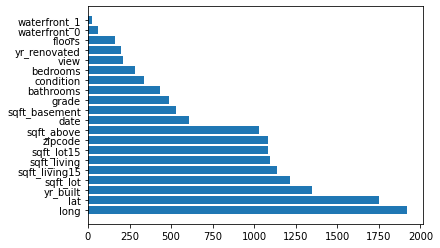

In [31]:
#lgbm 모델의 feature importance
imp_house = pd.DataFrame({'feature': train.columns, 
                                    'coefficient': model.feature_importances_})
imp_house = imp_house.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp_house['feature'], imp_house['coefficient'])
plt.show()

In [32]:
# create function to fit & predict, load and save file
# need to define model with params prior to using this function
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [33]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.160118')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160118.csv saved!
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=600, num_leaves=23, subsample=0.7; total time=   6.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=600, num_leaves=25, subsample=0.7; total time=   7.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=600, num_leaves=26, subsample=0.7; total time=   6.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=700, num_leaves=23, subsample=0.7; total time=   8.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=700, num_leaves=25, subsample=0.7; total time=   8.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=700, num_leaves=26, subsample=0.7; total time=   8.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=-1, n_estimators=800, num_leaves=23, subsample=0.7; total time=  

#### Private: 109640.44779 Public: 108499.98542 with RMSLE 0.160118